# Day 4: DBSCAN & Anomaly Detection

## 🎯 Learning Objectives
- Understand density-based clustering
- Detect market anomalies
- Build anomaly-based trading strategies

---

## 📚 Theory: DBSCAN

### Key Parameters
- **eps**: Neighborhood radius
- **min_samples**: Minimum points for core point

### Advantages
- Finds clusters of arbitrary shape
- Automatically identifies outliers
- No need to specify k

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

ticker = 'SPY'
end_date = datetime.now()
start_date = end_date - timedelta(days=10*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days")

📥 Downloading data...
✅ Data: 2513 days


In [2]:
# Create features for anomaly detection
df = pd.DataFrame(index=returns.index)
df['return'] = returns
df['return_abs'] = returns.abs()
df['volatility'] = returns.rolling(20).std() * np.sqrt(TRADING_DAYS)
df['volume_change'] = data['Volume'].pct_change()
df['price_range'] = (data['High'] - data['Low']) / data['Close']

df = df.dropna()
feature_cols = ['return', 'volatility', 'price_range']

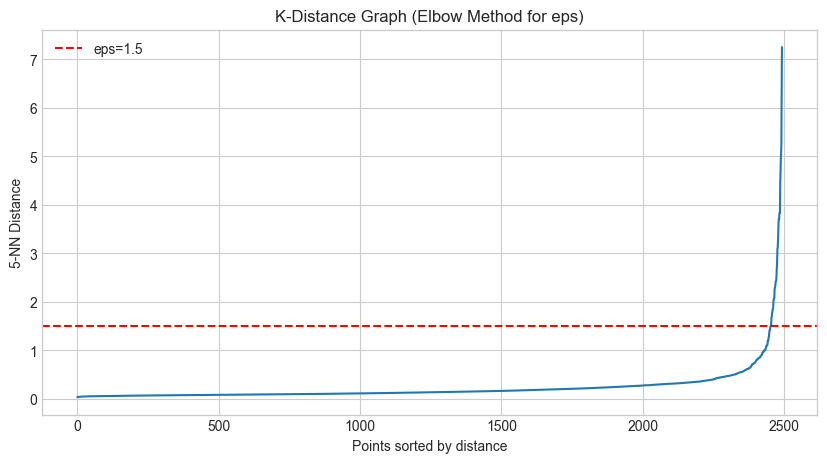

In [3]:
# Find optimal eps using k-distance graph
X = df[feature_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 5  # min_samples
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)
k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-NN Distance')
plt.title('K-Distance Graph (Elbow Method for eps)')
plt.axhline(y=1.5, color='r', linestyle='--', label='eps=1.5')
plt.legend()
plt.show()

In [4]:
# Apply DBSCAN
eps = 1.5
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
df['cluster'] = dbscan.fit_predict(X_scaled)

# -1 = outlier/anomaly
df['is_anomaly'] = (df['cluster'] == -1).astype(int)

n_anomalies = df['is_anomaly'].sum()
print(f"\n📊 Anomalies detected: {n_anomalies} ({n_anomalies/len(df)*100:.1f}%)")
print(f"Clusters found: {df['cluster'].nunique() - 1}")


📊 Anomalies detected: 34 (1.4%)
Clusters found: 2


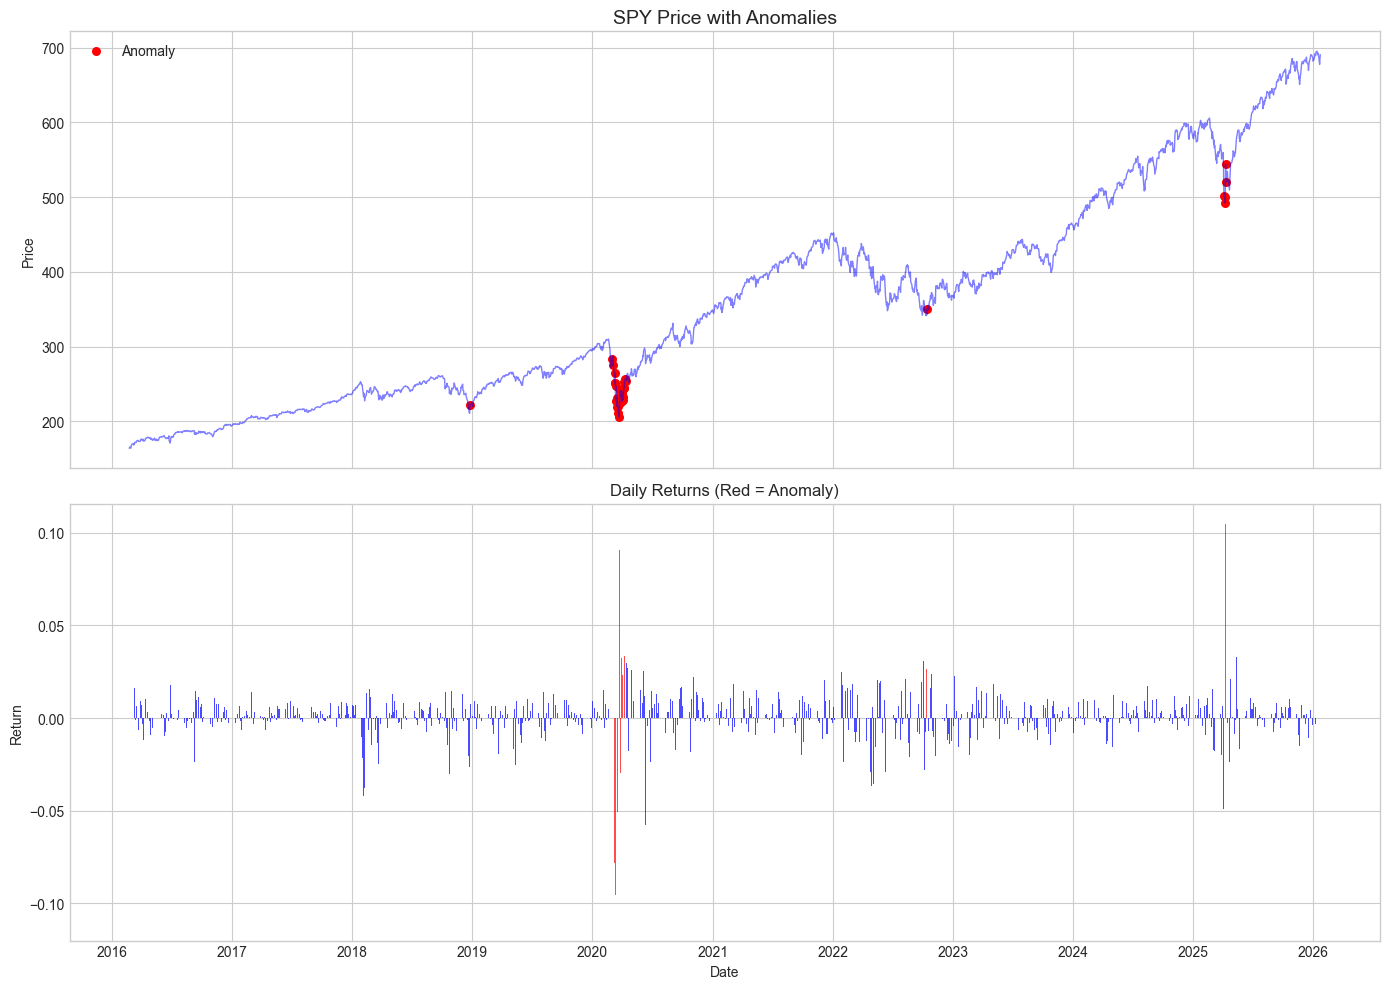

In [5]:
# Visualize anomalies
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Price with anomalies
price_aligned = prices.loc[df.index]
axes[0].plot(price_aligned.index, price_aligned.values, 'b-', alpha=0.5, linewidth=1)
anomaly_dates = df[df['is_anomaly'] == 1].index
axes[0].scatter(anomaly_dates, price_aligned.loc[anomaly_dates].values, c='red', s=30, label='Anomaly')
axes[0].set_title(f'{ticker} Price with Anomalies', fontsize=14)
axes[0].set_ylabel('Price')
axes[0].legend()

# Returns with anomalies
axes[1].bar(df.index, df['return'], color=['red' if a else 'blue' for a in df['is_anomaly']], alpha=0.7)
axes[1].set_title('Daily Returns (Red = Anomaly)')
axes[1].set_ylabel('Return')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

In [6]:
# Anomaly analysis
print("\n" + "="*60)
print("ANOMALY ANALYSIS")
print("="*60)

anomaly_df = df[df['is_anomaly'] == 1]
normal_df = df[df['is_anomaly'] == 0]

print(f"\n{'Metric':<20} {'Anomaly':>12} {'Normal':>12}")
print("-" * 50)
print(f"{'Mean Return':<20} {anomaly_df['return'].mean():>12.2%} {normal_df['return'].mean():>12.2%}")
print(f"{'Std Return':<20} {anomaly_df['return'].std():>12.2%} {normal_df['return'].std():>12.2%}")
print(f"{'Mean Volatility':<20} {anomaly_df['volatility'].mean():>12.1%} {normal_df['volatility'].mean():>12.1%}")


ANOMALY ANALYSIS

Metric                    Anomaly       Normal
--------------------------------------------------
Mean Return                 0.12%        0.06%
Std Return                  5.30%        0.96%
Mean Volatility             68.3%        14.1%


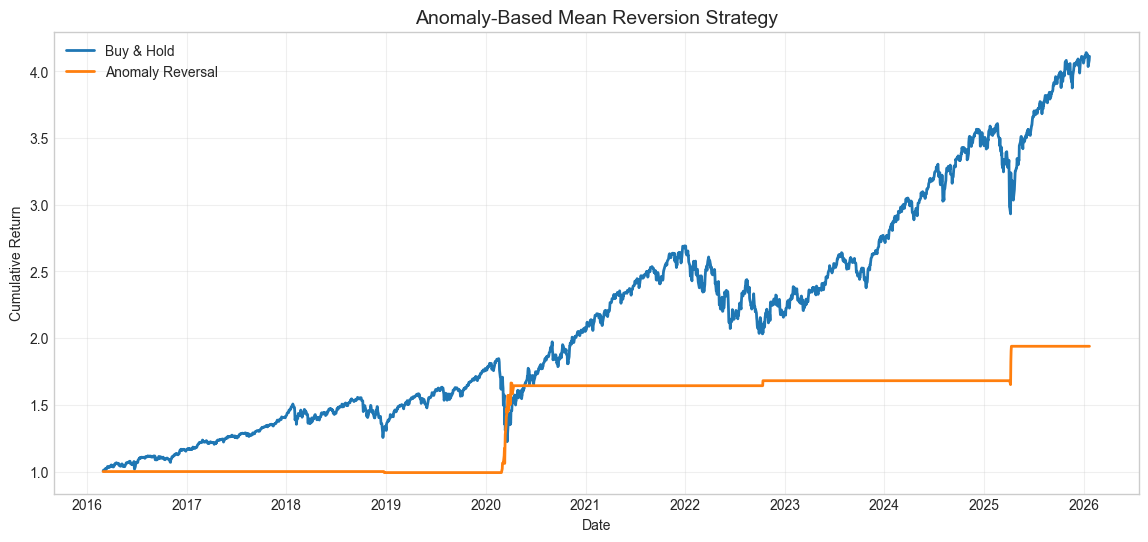

In [7]:
# Anomaly-based trading: Mean reversion after anomalies
df['next_return'] = df['return'].shift(-1)
df['next_5d_return'] = df['return'].shift(-1).rolling(5).sum()

# Signal: Trade opposite direction after anomaly
df['signal'] = 0
df.loc[(df['is_anomaly'] == 1) & (df['return'] < 0), 'signal'] = 1  # Buy after crash
df.loc[(df['is_anomaly'] == 1) & (df['return'] > 0), 'signal'] = -1  # Sell after spike

df['strategy_return'] = df['signal'] * df['next_return']
df = df.dropna()

df['strategy_cum'] = (1 + df['strategy_return']).cumprod()
df['buy_hold_cum'] = (1 + df['next_return']).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(df.index, df['strategy_cum'], label='Anomaly Reversal', linewidth=2)
plt.title('Anomaly-Based Mean Reversion Strategy', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
# Performance
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    win_rate = (returns > 0).mean()
    return total, sharpe, win_rate

# Only count when we trade
traded = df[df['signal'] != 0]
print(f"\n📊 Trades: {len(traded)}")

if len(traded) > 0:
    total, sharpe, win_rate = calc_metrics(traded['strategy_return'], df['strategy_cum'])
    print(f"Total Return: {total:.2%}")
    print(f"Win Rate: {win_rate:.1%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")


📊 Trades: 34
Total Return: 93.91%
Win Rate: 67.6%
Sharpe Ratio: 7.19


In [9]:
# Current anomaly status
latest_scaled = scaler.transform(df[feature_cols].iloc[[-1]])
is_anomaly = dbscan.fit_predict(X_scaled)[-1] == -1

print("\n" + "="*60)
print(f"📊 ANOMALY STATUS FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"\nLast Return: {df['return'].iloc[-1]:.2%}")
print(f"Current Volatility: {df['volatility'].iloc[-1]:.1%}")
print(f"Price Range: {df['price_range'].iloc[-1]:.2%}")
print(f"\nAnomaly Detected: {'⚠️ YES' if df['is_anomaly'].iloc[-1] else '✅ NO'}")
if df['is_anomaly'].iloc[-1]:
    signal = 'LONG (buy dip)' if df['return'].iloc[-1] < 0 else 'SHORT (sell spike)'
    print(f"\n🎯 Signal: {signal}")
else:
    print("\n🎯 Signal: No trade (normal conditions)")


📊 ANOMALY STATUS FOR SPY

Date: 2026-01-21

Last Return: 1.15%
Current Volatility: 10.7%
Price Range: 1.55%

Anomaly Detected: ✅ NO

🎯 Signal: No trade (normal conditions)


---

## 🏢 Real-World Applications

| Company | Anomaly Detection Use |
|---------|---------------------|
| Citadel | Flash crash detection |
| Two Sigma | Unusual activity alerts |
| JPMorgan | Fraud detection |

---
## 📅 Tomorrow: Gaussian Mixture Models